# Intro

Meanshift is a clustering algorithm in the same family as [K-Means](KMeansFromScratch.ipynb).  K-Means is the much more widely known well known clustering algorithm, but is advantageous in a lot of situations.

First, you don't have to decide how many clusters ahead of time.  This is important because in many datasets especially as they get very complex it can be hard to know how many clusters you really should have.  Meanshift requires bandwidth which is much easier to select.

Second, k-means looks at circular clusters.  You need to do some custom work to make it work for non-circular clusters.  Sometimes data doesn't split nicely into circular clusters.  Meanshift can handle clusters of any shape.

:::{.callout-note}
## Credit
This follows what Jeremy Howard did in a notebook as part of the [2022 part 2 course](https://www.fast.ai/posts/part2-2022.html).  I'm changing a few things, explaining things slightly different, and doing a few additional things - but his lecture covers the bulk of what in here and was the inspiration and starting point!  
:::

# Imports and setup

In [3]:
#| code-fold: true
import math, random, matplotlib.pyplot as plt, operator, torch
from functools import partial
from fastcore.all import *
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
import numpy as np

In [4]:
plt.style.use('dark_background')

In [5]:
#| code-fold: true
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [6]:
#| code-fold: true
def plot_data(centroids:torch.Tensor,# Centroid coordinates
              data:torch.Tensor, # Data Coordinates
              n_samples:int, # Number of samples
              ax:plt.Axes=None # Matplotlib Axes object
             )-> None:
    '''Creates a visualization of centroids and data points for clustering problems'''
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

# Generate Dataset

I'm using the same generated data that Jeremy did.  I refactored a bit, but it's the same thing.

In [7]:
def create_dataset(n_clusters,n_samples):
    centroids = torch.rand(n_clusters, 2)*70-35 # Points between -35 and 35
    def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
    data = torch.cat([sample(c) for c in centroids])
    return data,centroids

In [8]:
n_clusters = 6
n_samples = 250
data,centroids = create_dataset(n_clusters,n_samples)

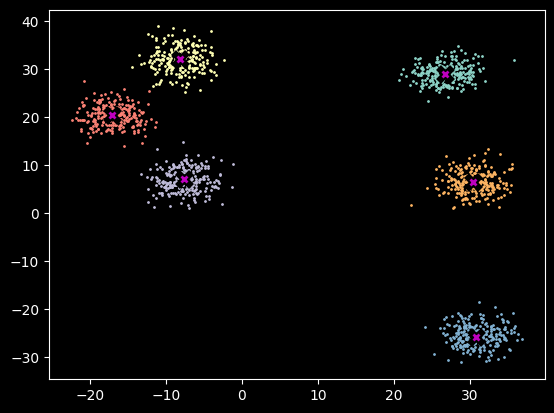

In [9]:
plot_data(centroids, data, n_samples)

# Meanshift

MeanShift is a clustering algorithm.  There's 3 main steps to the process.

:::{.callout-tip}
## Meanshift Algorithm

1. Calculate distances between every point
1. Calculate weights based on distance and bandwidth
1. Update centroid predictions using weights and distances to calculate weighted average

::::

Once you have those steps, you can repeat them until you have your final centroid locations

## Calculate Distance

In K-Means, you calculate the distance between each point and the cluster centroids.  In meanshift we calculate the distance between each point and every other point.  Given a tensor of centroid coordinates and a tensor of data coordinates we calculate distance.

:::{.callout-tip}
## Distance Calculation Steps
+ Subtract data points coordinates from all other data point coordinates
+ Take absolute value of distances
+ Pythagorean Calculation
    + Square coordinates
    + Add them together
    + Take the Square Root
:::

Let's put that in a function.

In [10]:
def calculate_distances(data:torch.Tensor # Data points you want to cluster
                       )-> torch.Tensor: # Tensor containing euclidean distance between each centroid and data point    
    '''Calculate distance between centroids and each datapoint'''
    axis_distances = data.reshape(-1,1,2).sub(data.reshape(1,-1,2))#.abs()
    euclid_distances = axis_distances.square().sum(axis=-1).sqrt()
    return euclid_distances

## Calculate weights

Next we need to create the weights.  There are 2 factors that go into calculating weights

+ How far away is this point from the other point?
+ What's the bandwidth?

The way we use this is we create a gaussian function to determine the weight based on distance.  That looks like this.

In [11]:
def gaussian(x): return torch.exp(-0.5*((x))**2) / (math.sqrt(2*math.pi))

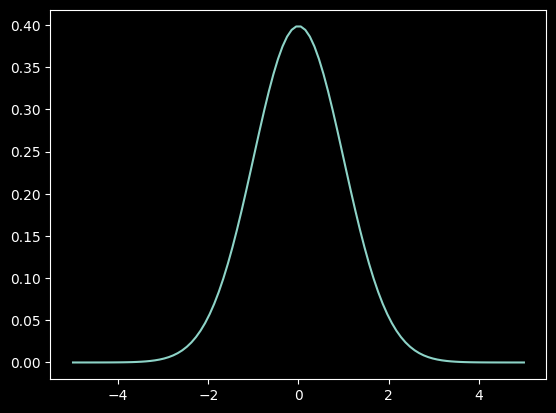

In [12]:
_x=torch.linspace(-5, 5, 100)
plt.plot(_x,gaussian(_x)); plt.show()

We modify the above slightly by adding a parameter called the bandwidth.  By adjusting the bandwidth we can adjust how fast or slow the weights decay as the distance increases.  A Gaussian with a bandwidth of 1 (middle chart) is just the normal distribution we saw above.  

Because distance is never negative, we don't need negative values

:::{.callout-tip}
The bandwidth is the standard deviation of the gaussian
:::

In [13]:
def gaussian(x, bw): return torch.exp(-0.5*((x/bw))**2) / (bw*math.sqrt(2*torch.pi))

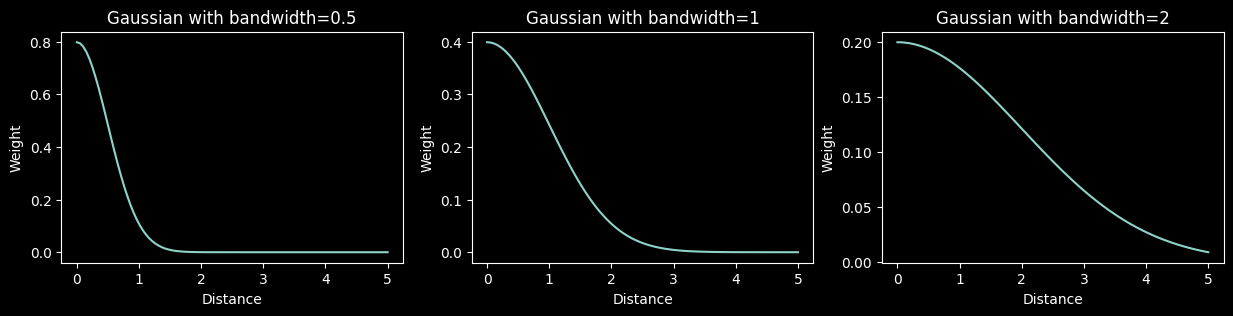

In [14]:
_x=torch.linspace(0, 5, 100)
fig,ax = plt.subplots(1,3,figsize=(15,3))
for a,bw in zip(ax,[.5,1,2]):
    a.plot(_x, gaussian(_x, bw))
    a.set_title(f"Gaussian with bandwidth={bw}")
    a.set_xlabel('Distance'); a.set_ylabel('Weight')
plt.show()

## Update Centroids

Now that we have our distance and weights we can update our centroid predictions and loop through until the points converge to give us cluster locations.  We do this by taking a weighted average of all the other points based (using the weights calculated previously).

In [15]:
def meanshift(X):
    dist = calculate_distances(X)
    weight = gaussian(dist, 2.5)
    X = weight@X/weight.sum(1,keepdim=True)
    return X

## All Together

Now that we have our meanshift function, we can create a function to run the model for several epochs and a function to plot the results.  A few nuances here:

+ I am making `run_exp` a higher order function so it's easy to try tweaks to the algorithm
+ I am testing if the coordinates change.  If coordinates do not change I consider it converged and stop the training.  I will run the model until it converges or after 100 epochs.

In [16]:
def run_exp(data,fn,max_epochs=100):
    coord = data.clone() 
    for i in range(max_epochs):
        _coord = fn(coord)
        if (i>0) and (coord==_coord).all()==True: break
        else:
            coord = _coord
            p_centroids = torch.unique(coord,dim=0)
    return p_centroids,coord,i

Next I create a couple functions to help me try things quickly and not have to scroll through duplicate print/plot code lines.

In [17]:
def plot_results(centroids,p_centroids):
    _,ax = plt.subplots()
    ax.scatter(p_centroids[:,0],p_centroids[:,1],label='Predicted',marker='x',s=200)
    ax.scatter(centroids[:,0],centroids[:,1],label='Target',marker='o',s=200,alpha=0.5)
    ax.legend()
    plt.show()

In [18]:
def print_results(fn,data):
    %timeit p_centroids,p_coord,p_epochs = run_exp(data,fn)
    p_centroids,p_coord,p_epochs = run_exp(data,fn)
    print(f"Algorithm found {p_centroids.shape[0]} Centroids in {p_epochs} epochs")
    plot_results(centroids,p_centroids)

# Train Algorithm

## Baseline

:::{.callout-note}

## Algorithm Results

+ Found the right number of centroids (6)
+ Converged in 9 epochs
+ Plot looks good - centroids are accurately placed
:::

In [19]:
def meanshift1(X):
    dist = calculate_distances(X)
    weight = gaussian(dist, 2.5)
    return weight@X/weight.sum(1,keepdim=True)

171 ms ± 6.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Algorithm found 6 Centroids in 9 epochs


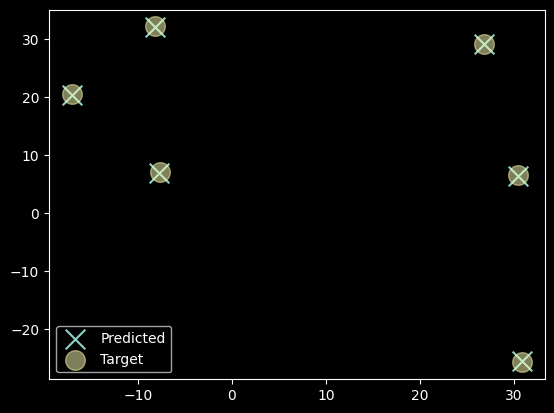

In [20]:
print_results(meanshift1,data)

## Ramp

I tried using a linear decline then flat at 0 instead of a gaussian to see if that speeds things up.  This was from Jeremy's lecture as an idea to try that seemed to work.

:::{.callout-note}

## Algorithm Results

+ Found the right number of centroids (6)
+ Converged in 9 epochs
+ Plot looks good - centroids are accurately placed
+ Ran in same speed as the gaussian.  I figure that might change if scaled up and put on a GPU with lots of data.  Worth more testing!
:::

In [21]:
def tri(d, i): return (-d+i).clamp_min(0)/i

In [22]:
def meanshift2(X):
    dist = calculate_distances(X)
    weight = tri(dist, 8)
    return weight@X/weight.sum(1,keepdim=True)

161 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Algorithm found 6 Centroids in 9 epochs


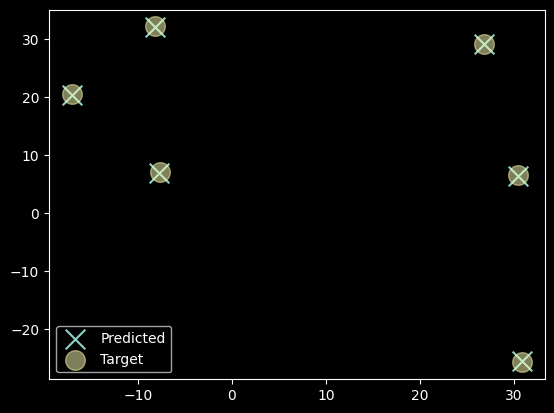

In [23]:
print_results(meanshift1,data)

## Sampling

This is the original meanshift (with gaussian) with a random sample of the data.  Even with 20% of the data it got really good centroids (though not perfect) but run much faster.  It also converged to 6 cluster in 8 epochs.  This seems useful.

:::{.callout-note}

## Algorithm Results

+ Found the right number of centroids (6)
+ Converged in 8 epochs
+ Plot looks good - centroids are reasonably accurately (but not perfectly) placed
+ Ran in less than 10% of the time of the original
+ Can control size of random sample based on needs (ie if more accuracy needed)
:::


31.4 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Algorithm found 6 Centroids in 9 epochs


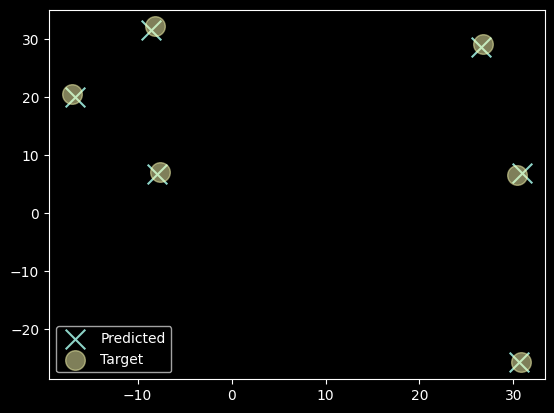

In [24]:
print_results(meanshift1,data[np.random.choice(len(data),300)])